In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt
import time
from math import radians, cos, sin, asin, sqrt

In [125]:
"""Load and Generate Data Functions"""
def combine_data(_master_df, date_index):
    raw_df = load_data(date_index)
    master_df = _master_df
    master_df = master_df.append(raw_df, ignore_index=True)
    return master_df

def load_data(date_index):
    path = r'data/{}-divvy-tripdata.csv'.format(date_index)
    df = pd.read_csv(path)
    return df

def generate_data(date_indices: list):
    master_df = load_data(date_indices[0])
    for date_index in date_indices[1:]:
        master_df = combine_data(master_df, date_index)
        
    master_df = master_df.sort_values(by=['started_at']).reset_index()
    master_df = master_df.drop(['index'], axis=1)
    return master_df


"""Helper Functions"""
def distance(lat1, lat2, lon1, lon2, units='kilometers'):
    
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    if units == 'kilometers':
        r = 6371
    elif units == 'miles':
        r = 3958.8
    elif units == 'meters':
        r = 6371 * 1000
        
    else:
        return error, 'Please specificy units (miles or kilometers)'

    # calculate the result
    return (c * r)

# function to return key for any value
def get_key(val, _dict):
    for key, value in _dict.items():
        if val == value:
            return key
    return "key doesn't exist"

def plot_stuff(data_dict):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.grid(axis='x')
    for item in data_dict:
        label_str = item
        ys = data_dict[item]
        xs = range(len(ys))
        ax.plot(xs, ys, marker='o', label=label_str)
    plt.legend()
    plt.show()
    
def filter_unique_list(_list):
    unique_list = []
    for x in _list:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list 

"""Null Values and Error Functions"""
def percent_null(_df, column_name: str, verbose=False):
    df = _df
    null_df = df.loc[pd.isna(df[column_name])]
    pcnt = round(len(null_df) / len(df) * 100, 3)
    if verbose:
        print(f'{pcnt}% null {column_name} values')
        print(f'{len(null_df)} null {column_name} out of {len(df)}')
    return pcnt

def nonevent_df_filter(df):
    # return all from from data frame where: 
    # 1: riders end at the same station they started with and
    # 2: total ride time under 2mins (1.2e11 nanoseconds)
    return df.loc[(df['start_station_id'] == df['end_station_id']) & (df['tr_time_nano'] < 1.2e11)]

def filter_negAndNone(_list: list) -> list:
    list_filter = filter(lambda item: item > 0, _list)
    return list(list_filter)

def hard_coded_outlier_removal(df):
    df = df.loc[df['distance_miles'] < 50.]
    return df



"""Data Generating Functions"""
def generate_columns_pack(df):
    df['distance_miles'] = [distance(df['start_lat'][x], df['end_lat'][x], df['start_lng'][x], df['end_lng'][x], units='miles') for x in range(len(df))]
#     df['distance_meters'] = [distance(df['start_lat'][x], df['end_lat'][x], df['start_lng'][x], df['end_lng'][x], units='meters') for x in range(len(df))]
    df['travel_time'] = [travel_time(df['started_at'][x], df['ended_at'][x]) for x in range(len(df))]
    time_delta_to_nano(df)
    weekday_num(df)
    return df

def travel_time(_start_time, _end_time):
    start_time = _start_time
    start_time = dt.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    end_time = _end_time
    end_time = dt.datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    time_change = end_time - start_time
    return time_change

def weekday_num(df):
    # (Mon, 0) (Tue, 1) (Wed, 2) (Th, 3) (Fri, 4) (Sat, 5) (Sun, 6)
    df['weekday_num'] = [dt.datetime.strptime(df.iloc[x, df.columns.get_loc('started_at')], "%Y-%m-%d %H:%M:%S").weekday() for x in range(len(df))]
    return df

def nano_to_mins(_nanos):
    seconds, nanos = divmod(_nanos, 1e9)
    nanos = int(nanos)
    mins, seconds = divmod(seconds, 60)
    mins_decimal = seconds/60
    value = mins + mins_decimal
    return value

def nano_to_time_str(_nano, incl_nano=False):
    seconds, nanos = divmod(_nano, 1e9)
    nanos = str(int(nanos))
    mins, seconds = divmod(seconds, 60)
    seconds = str(int(seconds))
    hours, mins = divmod(mins, 60)
    mins = str(int(mins))
    days, hours = divmod(hours, 24)
    hours = str(int(hours))
    days = str(int(days))
    if incl_nano:
        time_str = f'{days} days {hours}:{mins.zfill(2).zfill(2)}:{seconds.zfill(2)}.{nanos.zfill(9)}'
    else:
        time_str = f'{days} days {hours}:{mins.zfill(2).zfill(2)}:{seconds.zfill(2)}'
    return time_str

def time_delta_to_nano(df):
    df['tr_time_nano'] = pd.to_numeric(df['travel_time'], downcast='integer')
    return df

def leisure_df_filter(df):
    # return all from from data frame where: 
    # 1: riders end at the same station they started with and
    # 2: total ride time is above 10 mins (6e11 nanoseconds)
    return df.loc[(df['start_station_id'] == df['end_station_id']) & (df['tr_time_nano'] > 6e11)]

def nonleisure_df_filter(df):
    return df.loc[df['start_station_id'] != df['end_station_id']]

def distance_percentiles_df(df, index_name, units='miles'):
    percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
    distance_pcnts = []
    if units == 'miles':
        df = df[df['distance_miles'].notnull()]
        for percentile in percentiles:
            distance_pcnts.append(round(np.percentile(df['distance_miles'], percentile), 3))
    elif units == 'meters':
        df = df[df['distance_meter'].notnull()]
        for percentile in percentiles:
            distance_pcnts.append(round(np.percentile(df['distance_meters'], percentile), 3))
    
    percentiles_df = pd.DataFrame([distance_pcnts], columns = [percentiles], index = [index_name])
    return percentiles_df

def pcnt_of_df(df, total_df, name, member_casual, subgroup=None):
    total_count = len(total_df)
    pcnt_total = round(len(df) / total_count * 100, 2)
    pcnt_type = round(len(df) / len(total_df[total_df['member_casual'] == member_casual]) * 100, 2)
    pcnt_dict = {'count': len(df), 'out of total': [pcnt_total], 
                 f'out of {member_casual}': [pcnt_type]}
    
    if subgroup is not None:
        for item in subgroup:
            pcnt_dict[item] = round(len(df) / len(subgroup[item] * 100), 2) 
            
    pcnt_df = pd.DataFrame(pcnt_dict, index = [name])
    
    return pcnt_df

def pcnt_of_dict(count, total_df, name, member_casual, subgroup=None):
    total_count = len(total_df)
    pcnt_total = round(count / total_count * 100, 2)
    pcnt_type = round(count / len(total_df[total_df['member_casual'] == member_casual]) * 100, 2)
    pcnt_dict = { 'name': name,
                  'count': count, '/ OUT OF TOTAL': pcnt_total, 
                 f'/ OUT OF {member_casual.upper()}': pcnt_type}
    
    if subgroup is not None:
        for item in subgroup:
            item_str = f'/ {item.upper()}'
            pcnt_dict[item_str] = round(count / len(subgroup[item]) * 100, 2) 
    
    return pcnt_dict

def print_markdown_pcnt(dictionary, name, criteria):
    print(f'#### {name} By {criteria}')
    for item in dictionary:
        print_list = []
        for i in item:
            print_list.append((i, item[i]))
        print(f'__{print_list[1][1]} {print_list[0][1]}__')
    
        for i in print_list[2:]:
            print(f'{i[1]} % {i[0]}')

"""Stats based on days of the week"""
def generate_wkd_stats(df, plot=False):
    # (Mon, 0) (Tue, 1) (Wed, 2) (Th, 3) (Fri, 4) (Sat, 5) (Sun, 6)
    weekday_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Th': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
    weekday_count = Counter(df['weekday_num']).most_common()
    weekday_dict = {}
    for item in weekday_count:
        day_str = get_key(item[0], weekday_map)
        count = item[1]
        month_pcnt = round(count / len(df) * 100, 2)
        weekday_dict[item[0]] = (day_str, count)

    if plot:
        ys = [weekday_dict[i][1] for i in range(0, 7)]
        xs = [weekday_dict[i][0] for i in range(0, 7)]

        plt.figure(figsize=(12, 8))
        plt.plot(xs, ys)
        plt.show()
        
    return weekday_dict

def gen_wkd_stat(df):
    wkd_num_stat = df.groupby(['weekday_num']).agg({'distance_miles': ['mean', 'std'], 'tr_time_nano': ['mean', 'std']})
    wkd_mean_time = wkd_num_stat.apply(lambda x: nano_to_time_str(x.tr_time_nano['mean']), axis=1)
    wkd_std_time = wkd_num_stat.apply(lambda x: nano_to_time_str(x.tr_time_nano['std']), axis=1)
    return_data = {'mean_time' : wkd_mean_time,  'std_time': wkd_std_time, 
                   'mean_dist': wkd_num_stat.distance_miles['mean'], 'std_dist': wkd_num_stat.distance_miles['std']}
    return return_data

def plot_wkd_stat(df, columns):
    for item in columns:
        if len(item) > 1:
            subplot_num = len(item)
            for index, col in enumerate(item):
                xs = ['Mon', 'Tue', 'Wed', 'Th', 'Fri', 'Sat', 'Sun']
                ys = df[col].to_list()
                plt.subplot(1, subplot_num, index+1)
                y_limit = (np.max(df[col]) + (2.5 * np.std(df[col])))
                plt.xlim(-0.2, 7)
                plt.ylim(0, y_limit)
                plt.plot(xs, ys, marker='o', label=col)
                plt.title(col)
        else:
            col = item[0]
            fig, ax = plt.subplots(figsize=(6, 6))
            plt.grid(axis='x')
            xs = ['Mon', 'Tue', 'Wed', 'Th', 'Fri', 'Sat', 'Sun']
            ys = df[col].to_list()
            y_limit = (np.max(df[col]) + (2.5 * np.std(df[col])))
            plt.xlim(-0.2, 7)
            plt.ylim(0, y_limit)
            for index in range(len(xs)):
                ax.text(index + .1, ys[index] + np.std(ys), ys[index], size=12, rotation=0)

            ax.plot(xs, ys, marker='o', label=col)
            plt.title(col)
        plt.show()

def gen_wkd_ridetype_stats(df):
    ridetype_by_wkd = df.groupby(['weekday_num', 'rideable_type']).agg({'rideable_type': 'count'})
    # N = 3 Number of ridetypes classic, docked, and electric
    N = 3
    
    # getting a list of the raw values to be sorted and operated on
    wkd_cnt_list = [item for item in ridetype_by_wkd['rideable_type']]
    
    # group type counts by day (7 groups)
    cntlist = [wkd_cnt_list[n:n+N] for n in range(0, len(wkd_cnt_list), N)]
    
    # calculate the ridetype pcnts by day
    pcnt_list = []
    for item in cntlist:
        for element in item:
            pcnt_list.append(round(element / sum(item) * 100, 2))
            
    ridetype_list_for_cnt = ['classic_bike_cnt', 'docked_bike_cnt', 'electric_bike_cnt']
    ride_cnt_dict = {}
    cnt_list = [[x for x in wkd_cnt_list[::3]],
                [x for x in wkd_cnt_list[1::3]],
                [x for x in wkd_cnt_list[2::3]]]

    for name, data in zip(ridetype_list_for_cnt, cnt_list):
        ride_cnt_dict[name] = data

    ride_cnt_df = pd.DataFrame(ride_cnt_dict)
    ride_cnt_df = ride_cnt_df.T

    ridetype_list_for_pcnt = ['classic_bike_pcnt', 'docked_bike_pcnt', 'electric_bike_pcnt']
    ride_pcnt_dict = {}
    wkd_pcnt_list = [[x for x in pcnt_list[::3]],
                 [x for x in pcnt_list[1::3]],
                 [x for x in pcnt_list[2::3]]]

    for name, data in zip(ridetype_list_for_pcnt, wkd_pcnt_list):
        ride_pcnt_dict[name] = data

    ride_pcnt_df = pd.DataFrame(ride_pcnt_dict)
    ride_pcnt_df = ride_pcnt_df.T
    
    ridetype_stats_df = pd.concat([ride_cnt_df, ride_pcnt_df]).T
    for item in ridetype_list_for_cnt:
        ridetype_stats_df[item] = ridetype_stats_df[item].astype('int')
    return ridetype_stats_df

def generate_wkd_summary(df):
    # counts data
    wkd_counts_dict = generate_wkd_stats(df)
    wkd_counts_df = pd.DataFrame(wkd_counts_dict)
    wkd_counts_df = wkd_counts_df.reindex(columns= [i for i in range(7)])
    wkd_counts_df = wkd_counts_df.T
    wkd_counts_df = wkd_counts_df.rename(columns={0: 'day_str', 1: 'count'})
    
    # agg data
    wkd_stats_df = pd.DataFrame(gen_wkd_stat(df))
    wkd_stats_df[['mean_dist', 'std_dist']] = wkd_stats_df[['mean_dist', 'std_dist']].apply(lambda x: round(x, 3))
    
    # breakdown by ridetype
    wkd_ridetype_df = gen_wkd_ridetype_stats(df)
    
    result_df = pd.concat([wkd_counts_df, wkd_stats_df, wkd_ridetype_df], axis=1)
    
    return result_df

In [27]:
def gen_wkd_ridetype_stats_final(df):
    N = 21
    ridetype_categories = ['classic_bike', 'docked_bike', 'electric_bike']
    df_wkd_ridetype = df.groupby(['weekday_num', 'rideable_type']).agg({'rideable_type': 'count'})
    df_wkd_ridetype_categories = [df_wkd_ridetype.index[i][1] for i in range(len(df_wkd_ridetype))]
    df_wkd_ridetype_list = [item for item in df_wkd_ridetype['rideable_type']]
    
    if len(df_wkd_ridetype_categories) < N:
        df_wkd_ridetype_categories += [''] * (N - len(df_wkd_ridetype_categories))
        df_wkd_ridetype_list = [item for item in df_wkd_ridetype['rideable_type']]
        df_wkd_ridetype_list += [0] * (N - len(df_wkd_ridetype_list))
        df_wkd_ridetype_tuple_list = [(ridetype, cnt) for ridetype, cnt in
                                 zip(df_wkd_ridetype_categories, df_wkd_ridetype_list)]
        
        ideal_ridetype_categories_list = ridetype_categories * 7
        for index in range(N):
            if df_wkd_ridetype_tuple_list[index][0] != ideal_ridetype_categories_list[index]:
                df_wkd_ridetype_tuple_list.insert(index, (ideal_ridetype_categories_list[index], 0))
                df_wkd_ridetype_tuple_list = df_wkd_ridetype_tuple_list[:-1]
                
        df_wkd_ridetype_list = [df_wkd_ridetype_tuple_list[i][1] for i in range(len(df_wkd_ridetype_tuple_list))]
        
    # group type counts by day (7 groups)
    cntlist = [df_wkd_ridetype_list[n:n+3] for n in range(0, len(df_wkd_ridetype_list), 3)]
    
    # calculate the ridetype pcnts by day
    pcnt_list = []
    for item in cntlist:
        for element in item:
            pcnt_list.append(round(element / sum(item) * 100, 2))
            
    ridetype_list_for_cnt = ['classic_bike_cnt', 'docked_bike_cnt', 'electric_bike_cnt']
    ride_cnt_dict = {}
    cnt_list = [[x for x in df_wkd_ridetype_list[::3]],
                [x for x in df_wkd_ridetype_list[1::3]],
                [x for x in df_wkd_ridetype_list[2::3]]]

    for name, data in zip(ridetype_list_for_cnt, cnt_list):
        ride_cnt_dict[name] = data
        
    ride_cnt_df = pd.DataFrame(ride_cnt_dict)
    ride_cnt_df = ride_cnt_df.T
    
    ridetype_list_for_pcnt = ['classic_bike_pcnt', 'docked_bike_pcnt', 'electric_bike_pcnt']
    ride_pcnt_dict = {}
    wkd_pcnt_list = [[x for x in pcnt_list[::3]],
                     [x for x in pcnt_list[1::3]],
                     [x for x in pcnt_list[2::3]]]
    
    for name, data in zip(ridetype_list_for_pcnt, wkd_pcnt_list):
        ride_pcnt_dict[name] = data
        
    ride_pcnt_df = pd.DataFrame(ride_pcnt_dict)
    ride_pcnt_df = ride_pcnt_df.T
    
    ridetype_stats_df = pd.concat([ride_cnt_df, ride_pcnt_df]).T
    for item in ridetype_list_for_cnt:
        ridetype_stats_df[item] = ridetype_stats_df[item].astype('int')
    return ridetype_stats_df

In [126]:
def percentiles_df(df, index_name, subgroup_name):
    df = df[df[index_name].notnull()]
    percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
    pcnts = []
    for percentile in percentiles:
        pcnts.append(round(np.percentile(df[index_name], percentile), 2))
 
    percentiles_df = pd.DataFrame([pcnts], columns = [percentiles], index = [subgroup_name])
    return percentiles_df

def time_stats(df, subgroup_name):
    index_name = subgroup_name + ' time'
    agg_time = df.agg({'tr_time_nano': ['max', 'mean', 'std']})
    agg_time = agg_time.rename(columns={'tr_time_nano': index_name})
#     agg_time['time_str'] = agg_time['tr_time_nano'].apply(lambda x: nano_to_time_str(x))
    agg_time = agg_time.T
    
    percentile_time = percentiles_df(df, 'tr_time_nano', index_name)
    stats_df = pd.concat([percentile_time, agg_time], axis=1)
    
    for index in stats_df.columns[:15].to_list():
        stats_df = stats_df.rename(columns={index: index[0]})
    
    # `.T` tranpose used for easy column creation
    # will be tranposed again turning it into a row
    stats_df = stats_df.T
    stats_df[index_name] = stats_df[index_name].apply(lambda x: int(x))
    index_name2 = index_name + ' str'
    stats_df[index_name2] = stats_df[index_name].apply(lambda x: nano_to_time_str(x))
    stats_df = stats_df.T
    stats_df['measurement'] = 'time'
    stats_df['subgroup'] = [index_name, index_name2]
    
    return stats_df

# Avg Max, Std, Percentiles
def distance_stats(df, subgroup_name):
    index = subgroup_name + ' dist'
    agg_stats = df.agg({'distance_miles': ['max', 'mean', 'std']})
    agg_stats['distance_miles'] = agg_stats['distance_miles'].apply(lambda x: round(x, 2))
    agg_stats = agg_stats.rename(columns={'distance_miles': index})
    agg_stats = agg_stats.T
    percentile_stats = percentiles_df(df, 'distance_miles', index)
    stats_df = pd.concat([percentile_stats, agg_stats], axis=1)
    
    for index in stats_df.columns[:15].to_list():
        stats_df = stats_df.rename(columns={index: index[0]})
    stats_df['measurement'] = 'distance'
    stats_df['subgroup'] = subgroup_name
    return stats_df

def generate_time_dist_percentile_stats(df, subgroup_name):
    distance_stats = distance_stats(df, subgroup_name)
    time_stats = time_stats(df, subgroup_name)
    percentiles_df = pd.concat([distance_stats, time_stats], axis=0)
    return percentiles_df

def generate_wkd_stats(df, plot=False):
    # (Mon, 0) (Tue, 1) (Wed, 2) (Th, 3) (Fri, 4) (Sat, 5) (Sun, 6)
    weekday_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Th': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
    weekday_count = Counter(df['weekday_num']).most_common()
    weekday_dict = {}
    for item in weekday_count:
        day_str = get_key(item[0], weekday_map)
        count = item[1]
        month_pcnt = round(count / len(df) * 100, 2)
        weekday_dict[item[0]] = (day_str, count)

    if plot:
        ys = [weekday_dict[i][1] for i in range(0, 7)]
        xs = [weekday_dict[i][0] for i in range(0, 7)]

        plt.figure(figsize=(12, 8))
        plt.plot(xs, ys)
        plt.show()
        
    return weekday_dict

def generate_wkd_summary(df):
    # counts data
    wkd_counts_dict = generate_wkd_stats(df)
    wkd_counts_df = pd.DataFrame(wkd_counts_dict)
    wkd_counts_df = wkd_counts_df.reindex(columns= [i for i in range(7)])
    wkd_counts_df = wkd_counts_df.T
    wkd_counts_df = wkd_counts_df.rename(columns={0: 'day_str', 1: 'count'})
    
    # agg data
    wkd_stats_df = pd.DataFrame(gen_wkd_stat(df))
    wkd_stats_df[['mean_dist', 'std_dist']] = wkd_stats_df[['mean_dist', 'std_dist']].apply(lambda x: round(x, 3))
    
    # breakdown by ridetype
    wkd_ridetype_df = gen_wkd_ridetype_stats_final(df)
    
    result_list = [wkd_counts_df, wkd_stats_df, wkd_ridetype_df]
    
    result_df = pd.concat([wkd_counts_df, wkd_stats_df, wkd_ridetype_df], axis=1)
    
    return result_df

def generate_percentile_stats(df, subgroup_name):
    distance_percentiles = distance_stats(df, subgroup_name)
    time_percentiles = time_stats(df, subgroup_name)
    percentiles_df = pd.concat([distance_percentiles, time_percentiles], axis=0)
    return percentiles_df

def generate_time_dist_percentile_stats(df, subgroup_name):
    distance_stats = distance_stats(df, subgroup_name)
    time_stats = time_stats(df, subgroup_name)
    percentiles_df = pd.concat([distance_stats, time_stats], axis=0)
    return percentiles_df

def percent_of_dict(df, total_df, name):
    count = len(df)
    total_count = len(total_df)
    pcnt = round(count / total_count * 100, 2)
    pcnt_dict = {'name': name,
                 'count': count,
                 'pcnt': pcnt}
    return pcnt_dict

def plot_percentiles(data_dict):
    percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xticks(percentiles)
    plt.grid(axis='x')
    for item in data_dict:
        label_str = item
        ys = data_dict[item]
        xs = percentiles
        ax.plot(xs, ys, marker='o', label=label_str)
    plt.legend()
    plt.show()

In [72]:
def generate_overall_summary_dict(df, subgroup_name):
    # use for months and then aggregated df
    casual = df[df['member_casual'] == 'casual']
    member = df[df['member_casual'] == 'member']
    leisure = leisure_df_filter(df)
    non_leisure = nonleisure_df_filter(df)
    non_events = nonevent_df_filter(df)
    subgroups = {'overall': df, 'casual': casual, 'member': member, 'leisure': leisure, 'non_leisure': non_leisure}
    summary_dict = {}
    subgroup_wkd_dict = {}
    cnt_pcnt_dict = {}
    percentile_dict = {}
    for item in subgroups:
        entry_name = f'{item} {subgroup_name}'
        sub_df = subgroups[item]
        cnt_pcnt_dict[item] = percent_of_dict(sub_df, df, entry_name)
        subgroup_wkd_dict[item] = generate_wkd_summary(sub_df)
        percentile_dict[item] = generate_percentile_stats(sub_df, entry_name)
        
    summary_dict['cnt_pcnt_stats'] = cnt_pcnt_dict
    summary_dict['wkd_dict'] = subgroup_wkd_dict
    summary_dict['percentile_dict'] = percentile_dict
    
    return summary_dict

In [73]:
date_indices = ['202101',
                '202102',
                '202103',
                '202104',
                '202105',
                '202106',
                '202107',
                '202108',
                '202109',
                '202110',
                '202111',
                '202112',
                '202201']

In [22]:
month_df_dict = {}

for index in date_indices:
    month_df_dict[index] = load_data(index)

In [74]:
month_stats_dict = {}

for index in month_df_dict:
    print(index)
    df = month_df_dict[index]
    month_stats_dict[index] = generate_overall_summary_dict(df, index)

202101
202102
202103
202104
202105
202106
202107
202108
202109
202110
202111
202112
202201


In [75]:
month_stats_dict['202101']['wkd_dict']['overall']

,day_str,count,mean_time,std_time,mean_dist,std_dist,classic_bike_cnt,docked_bike_cnt,electric_bike_cnt,classic_bike_pcnt,docked_bike_pcnt,electric_bike_pcnt
0,Mon,13223,0 days 0:14:22,0 days 0:47:08,1.194,1.057,8565,201,4457,64.77,1.52,33.71
1,Tue,12451,0 days 0:13:35,0 days 0:41:39,1.199,1.063,8151,197,4103,65.46,1.58,32.95
2,Wed,13302,0 days 0:15:22,0 days 1:12:29,1.208,1.073,8612,233,4457,64.74,1.75,33.51
3,Th,14316,0 days 0:13:47,0 days 0:37:51,1.195,1.058,9231,236,4849,64.48,1.65,33.87
4,Fri,15483,0 days 0:14:16,0 days 0:45:09,1.173,1.057,9608,318,5557,62.06,2.05,35.89
5,Sat,16323,0 days 0:18:01,0 days 2:40:56,1.252,1.130,10189,569,5565,62.42,3.49,34.09
6,Sun,11736,0 days 0:17:13,0 days 1:25:43,1.209,1.095,7344,352,4040,62.58,3.00,34.42


In [76]:
month_stats_dict['202101']['wkd_dict']['non_leisure']

,day_str,count,mean_time,std_time,mean_dist,std_dist,classic_bike_cnt,docked_bike_cnt,electric_bike_cnt,classic_bike_pcnt,docked_bike_pcnt,electric_bike_pcnt
0,Mon,12676,0 days 0:13:59,0 days 0:47:33,1.246,1.049,8197,138,4341,64.67,1.09,34.25
1,Tue,11918,0 days 0:13:19,0 days 0:42:15,1.252,1.055,7783,144,3991,65.30,1.21,33.49
2,Wed,12715,0 days 0:15:05,0 days 1:13:45,1.264,1.065,8187,185,4343,64.39,1.45,34.16
3,Th,13642,0 days 0:13:26,0 days 0:37:19,1.254,1.049,8751,172,4719,64.15,1.26,34.59
4,Fri,14784,0 days 0:13:51,0 days 0:44:57,1.228,1.049,9132,248,5404,61.77,1.68,36.55
5,Sat,15410,0 days 0:17:15,0 days 2:44:38,1.326,1.120,9596,454,5360,62.27,2.95,34.78
6,Sun,11025,0 days 0:16:24,0 days 1:23:57,1.287,1.085,6886,248,3891,62.46,2.25,35.29


In [70]:
month_stats_dict['202101']['cnt_pcnt_stats']

{'overall': {'name': 'overall 202101', 'count': 96834, 'pcnt': 100.0},
 'casual': {'name': 'casual 202101', 'count': 18117, 'pcnt': 18.71},
 'member': {'name': 'member 202101', 'count': 78717, 'pcnt': 81.29},
 'leisure': {'name': 'leisure 202101', 'count': 2868, 'pcnt': 2.96},
 'non_leisure': {'name': 'non_leisure 202101', 'count': 92170, 'pcnt': 95.18}}

In [89]:
month_stats_dict['202103']['percentile_dict']['casual'] #.iloc[0].tolist()

,1,5,10,20,25,30,40,50,60,70,75,80,90,95,99,max,mean,std,measurement,subgroup
casual 202103 dist,0.0,0.0,0.0,0.32,0.45,0.57,0.78,0.98,1.23,1.55,1.75,2.03,2.86,3.74,6.07,18.69,1.3,1.29,distance,casual 202103
casual 202103 time,55000000000,252000000000,357000000000,522000000000,602000000000,687000000000,878000000000,1123000000000,1440000000000,1842000000000,2136000000000,2549000000000,3976000000000,5598000000000,11059559999999,1900899000000000,2289523889424,15117053000892,time,casual 202103 time
casual 202103 time str,0 days 0:00:55,0 days 0:04:12,0 days 0:05:57,0 days 0:08:42,0 days 0:10:02,0 days 0:11:27,0 days 0:14:38,0 days 0:18:43,0 days 0:24:00,0 days 0:30:42,0 days 0:35:36,0 days 0:42:29,0 days 1:06:16,0 days 1:33:18,0 days 3:04:19,22 days 0:01:39,0 days 0:38:09,0 days 4:11:57,time,casual 202103 time str


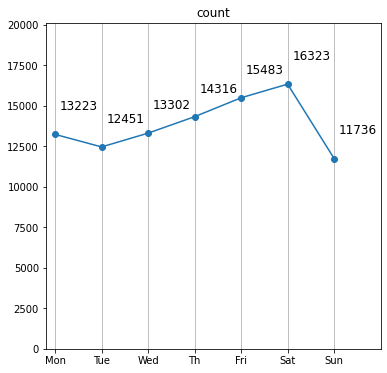

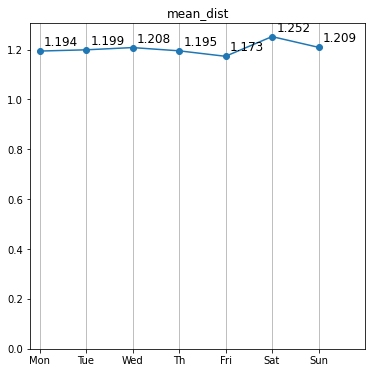

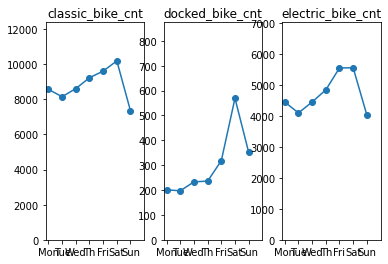

In [77]:
df_202101 = month_stats_dict['202101']['wkd_dict']['overall']
plot_wkd_stat(df_202101, [['count'], ['mean_dist'], ['classic_bike_cnt', 'docked_bike_cnt', 'electric_bike_cnt']])

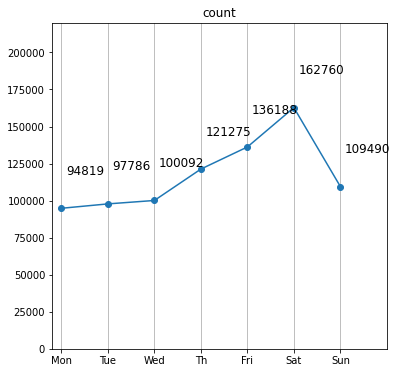

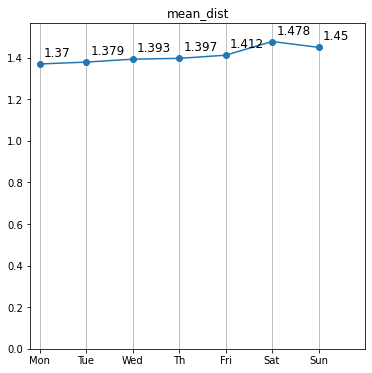

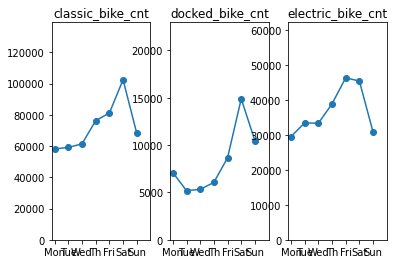

In [78]:
df_202101 = month_stats_dict['202107']['wkd_dict']['overall']
plot_wkd_stat(df_202101, [['count'], ['mean_dist'], ['classic_bike_cnt', 'docked_bike_cnt', 'electric_bike_cnt']])

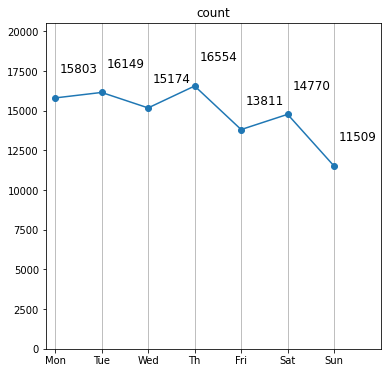

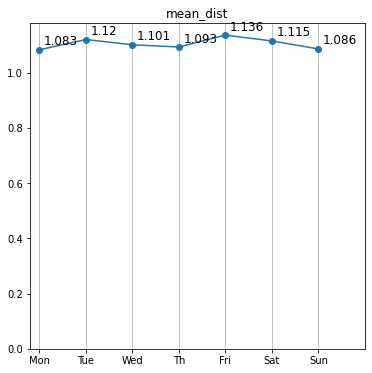

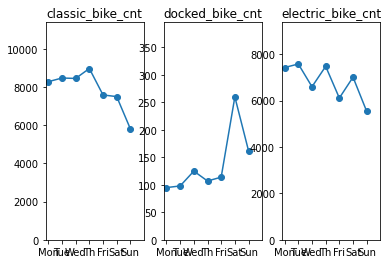

In [79]:
df_202101 = month_stats_dict['202201']['wkd_dict']['overall']
plot_wkd_stat(df_202101, [['count'], ['mean_dist'], ['classic_bike_cnt', 'docked_bike_cnt', 'electric_bike_cnt']])

In [91]:
month_stats_dict['202201']['cnt_pcnt_stats']

{'overall': {'name': 'overall 202201', 'count': 103770, 'pcnt': 100.0},
 'casual': {'name': 'casual 202201', 'count': 18520, 'pcnt': 17.85},
 'member': {'name': 'member 202201', 'count': 85250, 'pcnt': 82.15},
 'leisure': {'name': 'leisure 202201', 'count': 1698, 'pcnt': 1.64},
 'non_leisure': {'name': 'non_leisure 202201', 'count': 100282, 'pcnt': 96.64}}

In [109]:
month_cnt_overall = []
month_cnt_casual = []
month_cnt_member = []
month_cnt_leisure = []
month_cnt_non_leisure = []


for index in date_indices:
    print(index)
    month_cnt_overall.append(month_stats_dict[index]['cnt_pcnt_stats']['overall']['count'])
    month_cnt_casual.append(month_stats_dict[index]['cnt_pcnt_stats']['casual']['count'])
    month_cnt_member.append(month_stats_dict[index]['cnt_pcnt_stats']['member']['count'])
    month_cnt_leisure.append(month_stats_dict[index]['cnt_pcnt_stats']['leisure']['count'])
    month_cnt_non_leisure.append(month_stats_dict[index]['cnt_pcnt_stats']['non_leisure']['count'])
    
month_cnt_dict = {'overall': month_cnt_overall,
                  'casual': month_cnt_casual,
                  'member': month_cnt_member}        # ,
#                   'leisure': month_cnt_leisure,
#                   'non_leisure': month_cnt_non_leisure}

202101
202102
202103
202104
202105
202106
202107
202108
202109
202110
202111
202112
202201


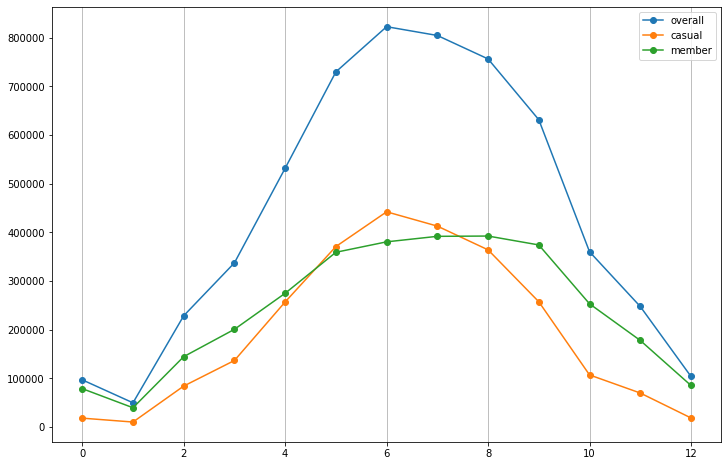

In [110]:
plot_stuff(month_cnt_dict)

In [123]:
month_stats_dict['202101']['percentile_dict']['overall'].iloc[2]

1                       0 days 0:00:32
5                       0 days 0:02:34
10                      0 days 0:03:31
20                      0 days 0:04:54
25                      0 days 0:05:33
30                      0 days 0:06:12
40                      0 days 0:07:36
50                      0 days 0:09:18
60                      0 days 0:11:26
70                      0 days 0:14:21
75                      0 days 0:16:19
80                      0 days 0:18:46
90                      0 days 0:27:18
95                      0 days 0:36:16
99                      0 days 1:16:22
max                   13 days 18:25:55
mean                    0 days 0:15:16
std                     0 days 1:23:56
measurement                       time
subgroup       overall 202101 time str
Name: overall 202101 time str, dtype: object

In [122]:
month_stats_dict['202107']['percentile_dict']['overall'].iloc[2]

1                       0 days 0:00:30
5                       0 days 0:03:01
10                      0 days 0:04:25
20                      0 days 0:06:34
25                      0 days 0:07:35
30                      0 days 0:08:37
40                      0 days 0:10:48
50                      0 days 0:13:21
60                      0 days 0:16:31
70                      0 days 0:20:50
75                      0 days 0:23:44
80                      0 days 0:27:26
90                      0 days 0:41:09
95                      0 days 1:02:19
99                      0 days 2:21:24
max                    34 days 2:27:09
mean                    0 days 0:24:12
std                     0 days 3:34:11
measurement                       time
subgroup       overall 202107 time str
Name: overall 202107 time str, dtype: object

In [134]:
month_stats_dict['202110']['wkd_dict']['casual']

,day_str,count,mean_time,std_time,mean_dist,std_dist,classic_bike_cnt,docked_bike_cnt,electric_bike_cnt,classic_bike_pcnt,docked_bike_pcnt,electric_bike_pcnt
0,Mon,22052,0 days 0:26:05,0 days 3:34:58,1.334,1.213,8180,1891,11981,37.09,8.58,54.33
1,Tue,27082,0 days 0:22:19,0 days 1:50:41,1.379,1.219,9830,1800,15452,36.30,6.65,57.06
2,Wed,26859,0 days 0:22:34,0 days 3:52:07,1.391,1.224,9470,1650,15739,35.26,6.14,58.60
3,Th,22329,0 days 0:22:26,0 days 3:39:13,1.341,1.177,7798,1185,13346,34.92,5.31,59.77
4,Fri,39531,0 days 0:27:09,0 days 4:24:30,1.389,1.204,15692,3256,20583,39.70,8.24,52.07
5,Sat,66747,0 days 0:31:19,0 days 4:26:18,1.469,1.318,30322,7144,29281,45.43,10.70,43.87
6,Sun,52642,0 days 0:36:33,0 days 5:13:38,1.464,1.288,24297,5958,22387,46.16,11.32,42.53


In [136]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_miles,travel_time,tr_time_nano,weekday_num
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual,0.434683,0 days 00:02:57,177000000000,3
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual,0.431436,0 days 00:04:21,261000000000,0
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member,0.621895,0 days 00:04:21,261000000000,1
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual,1.530317,0 days 00:14:56,896000000000,1
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member,0.506136,0 days 00:06:02,362000000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103765,8788DA3EDE8FD8AB,electric_bike,2022-01-18 12:36:48,2022-01-18 12:46:19,Clinton St & Washington Blvd,WL-012,NaN,NaN,41.883436,-87.641391,41.890000,-87.620000,casual,1.190120,0 days 00:09:31,571000000000,1
103766,C6C3B64FDC827D8C,electric_bike,2022-01-27 11:00:06,2022-01-27 11:02:40,Racine Ave & Randolph St,13155,NaN,NaN,41.884158,-87.656977,41.880000,-87.650000,casual,0.459696,0 days 00:02:34,154000000000,3
103767,CA281AE7D8B06F5A,electric_bike,2022-01-10 16:14:51,2022-01-10 16:20:58,Broadway & Waveland Ave,13325,Clark St & Grace St,TA1307000127,41.949066,-87.648611,41.950780,-87.659172,casual,0.555462,0 days 00:06:07,367000000000,0
103768,44E348991862319B,electric_bike,2022-01-19 13:22:11,2022-01-19 13:24:27,Racine Ave & Randolph St,13155,NaN,NaN,41.884005,-87.657031,41.880000,-87.660000,casual,0.316105,0 days 00:02:16,136000000000,2
